<a href="https://colab.research.google.com/github/SMN-SENAMHI/MONITOREO/blob/main/ERA5_SURFACE_DAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.cpu_count()


2

In [2]:
# Instalación silenciosa de librerías Python
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp

# Instalación silenciosa de dependencias del sistema
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1

# Instalación silenciosa de Cartopy
!pip install -q cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 104.8 MB/s eta 0:00:00


In [3]:
# ==============================================
# Guardar token en Colab (.netrc)
# ==============================================

#Reemplaza con tu token segun usuario registrado
#TOKEN = "edh_pat_cfdba8b50c493e84dfc676f5f1efed1794dde11c40cd21237e54c21da72c2f9378c792defeb8e2ca4638ac478df26ab8"
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo .netrc en /root
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Ajustar permisos (requerido por seguridad)
!chmod 600 /root/.netrc


In [6]:
!pip install -q xarray zarr fsspec requests

import xarray as xr
import pandas as pd

# ========================
# ABRIR DATASET ERA5
# ========================
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr"

ds = xr.open_dataset(
    url,
    storage_options={"client_kwargs": {"trust_env": True}},
    chunks={},
    engine="zarr",
)

# ========================
# LISTAR VARIABLES
# ========================
print("📌 Variables disponibles:")
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "")
    desc = ds[var].attrs.get("long_name", "")
    print(f" - {var}: {desc} [{units}]")

# ========================
# DETECTAR COORDENADA TEMPORAL
# ========================
# buscamos cuál de las coordenadas tiene tipo datetime
time_coord = None
for coord in ds.coords:
    if "datetime64" in str(ds[coord].dtype):
        time_coord = coord
        break

if time_coord is None:
    raise ValueError("⚠️ No se encontró coordenada temporal con formato datetime")

# ========================
# RANGO TEMPORAL
# ========================
t0 = pd.to_datetime(ds[time_coord][0].values)
tf = pd.to_datetime(ds[time_coord][-1].values)

print("\n📅 Rango temporal del dataset:")
print("Coordenada temporal:", time_coord)
print("Inicio :", t0.strftime("%Y-%m-%d %H:%M:%S"))
print("Fin    :", tf.strftime("%Y-%m-%d %H:%M:%S"))



📌 Variables disponibles:
 - alnid: Near IR albedo for diffuse radiation (climatological) [(0 - 1)]
 - alnip: Near IR albedo for direct radiation (climatological) [(0 - 1)]
 - aluvd: UV visible albedo for diffuse radiation (climatological) [(0 - 1)]
 - aluvp: UV visible albedo for direct radiation (climatological) [(0 - 1)]
 - anor: Angle of sub-gridscale orography [radians]
 - asn: Snow albedo [(0 - 1)]
 - bld: Time-integrated boundary layer dissipation [J m**-2]
 - blh: Boundary layer height [m]
 - cape: Convective available potential energy [J kg**-1]
 - cdir: Surface direct short-wave radiation, clear sky [J m**-2]
 - chnk: Charnock [Numeric]
 - cin: Convective inhibition [J kg**-1]
 - cl: Lake cover [(0 - 1)]
 - cp: Convective precipitation [m]
 - crr: Convective rain rate [kg m**-2 s**-1]
 - csf: Convective snowfall [m of water equivalent]
 - csfr: Convective snowfall rate water equivalent [kg m**-2 s**-1]
 - cvh: High vegetation cover [(0 - 1)]
 - cvl: Low vegetation cover [(0 - 

📅 Última fecha disponible: 2025-08-31 23:00:00


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Do

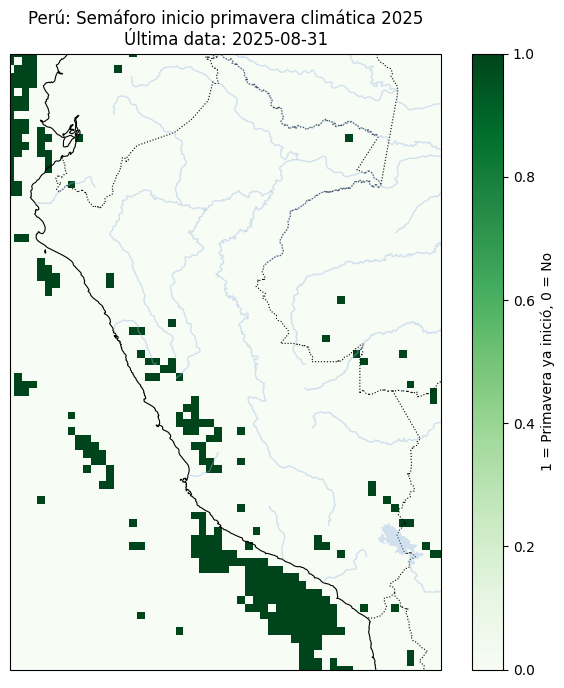

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ========================
# CONFIGURACIÓN PARA PERÚ
# ========================
lat_range = slice(0, -20)         # Perú: norte a sur
lon_range = slice(278, 292)       # Perú en 0–360° (≈ -82 a -68)
umbral_temp = 0.5   # °C sobre la climatología
umbral_pp   = 0.0   # mm sobre la climatología
dias_consec = 5
time_coord  = "valid_time"

# ========================
# ASEGURAR FECHAS
# ========================
ds[time_coord] = pd.to_datetime(ds[time_coord].values)
ultima_fecha = pd.to_datetime(ds[time_coord][-1].values)
print("📅 Última fecha disponible:", ultima_fecha)

# ========================
# VARIABLES (°C y mm)
# ========================
mn2t = ds["mn2t"].sel(latitude=lat_range, longitude=lon_range) - 273.15
mx2t = ds["mx2t"].sel(latitude=lat_range, longitude=lon_range) - 273.15
tp   = ds["tp"].sel(latitude=lat_range, longitude=lon_range) * 1000.0

# ========================
# HORARIO → DIARIO
# ========================
tmin_diaria = mn2t.resample({time_coord: "1D"}).min()
tmax_diaria = mx2t.resample({time_coord: "1D"}).max()
pp_diaria   = tp.resample({time_coord: "1D"}).sum()

# ========================
# CLIMATOLOGÍA 1991–2020
# ========================
clim_tmin = tmin_diaria.sel({time_coord: slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()
clim_tmax = tmax_diaria.sel({time_coord: slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()
clim_pp   = pp_diaria.sel({time_coord: slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()

# ========================
# DATOS 2025
# ========================
tmin_2025 = tmin_diaria.sel({time_coord: slice("2025-01-01", ultima_fecha)})
tmax_2025 = tmax_diaria.sel({time_coord: slice("2025-01-01", ultima_fecha)})
pp_2025   = pp_diaria.sel({time_coord: slice("2025-01-01", ultima_fecha)})

# ========================
# DETECCIÓN INICIO PRIMAVERA
# ========================
doy_inicio = xr.full_like(tmin_2025.isel({time_coord: 0}), np.nan)
contador   = xr.zeros_like(doy_inicio)

for i, fecha in enumerate(tmin_2025[time_coord].values):
    doy = pd.to_datetime(fecha).dayofyear

    mask_tmin = tmin_2025.isel({time_coord: i}) > clim_tmin.sel(dayofyear=doy) + umbral_temp
    mask_tmax = tmax_2025.isel({time_coord: i}) > clim_tmax.sel(dayofyear=doy) + umbral_temp
    mask_pp   = pp_2025.isel({time_coord: i})   > clim_pp.sel(dayofyear=doy)   + umbral_pp

    mask = mask_tmin & mask_tmax & mask_pp
    contador = xr.where(mask, contador + 1, 0)
    doy_inicio = xr.where((contador >= dias_consec) & np.isnan(doy_inicio), doy, doy_inicio)

# ========================
# MAPA CON CARTOPY
# ========================
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())

mask_inicio = ~np.isnan(doy_inicio)

im = mask_inicio.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Greens",
    add_colorbar=True,
    cbar_kwargs={"label": "1 = Primavera ya inició, 0 = No"}
)

# Añadir capas geográficas
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.RIVERS, alpha=0.4)

# Enfocar en Perú
ax.set_extent([-82, -68, -20, 0], crs=ccrs.PlateCarree())

# Título
ax.set_title(f"Perú: Semáforo inicio primavera climática 2025\nÚltima data: {ultima_fecha.date()}")

plt.show()


📅 Última fecha disponible: 2025-08-31 23:00:00


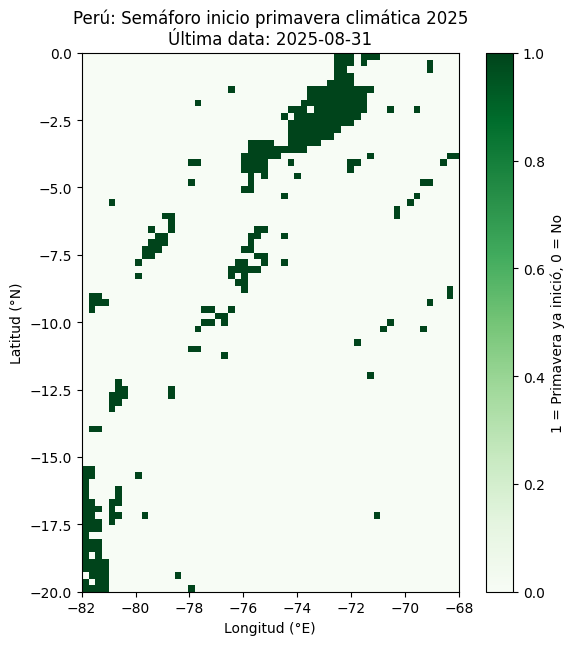

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# ========================
# CONFIGURACIÓN PARA PERÚ
# ========================
lat_range = slice(0, -20)         # Perú: norte a sur
lon_range = slice(278, 292)       # Perú en 0–360° (≈ -82 a -68)

umbral_temp = 0.5   # °C sobre la climatología
umbral_pp   = 0.0   # mm sobre la climatología
dias_consec = 5
time_coord  = "valid_time"

# ========================
# ASEGURAR FECHAS
# ========================
ds[time_coord] = pd.to_datetime(ds[time_coord].values)
ultima_fecha = pd.to_datetime(ds[time_coord][-1].values)
print("📅 Última fecha disponible:", ultima_fecha)

# ========================
# VARIABLES (°C y mm)
# ========================
mn2t = ds["mn2t"].sel(latitude=lat_range, longitude=lon_range) - 273.15
mx2t = ds["mx2t"].sel(latitude=lat_range, longitude=lon_range) - 273.15
tp   = ds["tp"].sel(latitude=lat_range, longitude=lon_range) * 1000.0

# ========================
# HORARIO → DIARIO
# ========================
tmin_diaria = mn2t.resample(valid_time="1D").min()
tmax_diaria = mx2t.resample(valid_time="1D").max()
pp_diaria   = tp.resample(valid_time="1D").sum()

# ========================
# CLIMATOLOGÍA 1991–2020
# ========================
clim_tmin = tmin_diaria.sel({time_coord:slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()
clim_tmax = tmax_diaria.sel({time_coord:slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()
clim_pp   = pp_diaria.sel({time_coord:slice("1991-01-01","2020-12-31")}) \
                      .groupby(f"{time_coord}.dayofyear").mean()

# ========================
# DATOS 2025
# ========================
tmin_2025 = tmin_diaria.sel({time_coord:slice("2025-01-01", ultima_fecha)})
tmax_2025 = tmax_diaria.sel({time_coord:slice("2025-01-01", ultima_fecha)})
pp_2025   = pp_diaria.sel({time_coord:slice("2025-01-01", ultima_fecha)})

# ========================
# DETECCIÓN INICIO PRIMAVERA
# ========================
doy_inicio = xr.full_like(tmin_2025.isel({time_coord:0}), np.nan)
contador   = xr.zeros_like(doy_inicio)

for i, fecha in enumerate(tmin_2025[time_coord].values):
    doy = pd.to_datetime(fecha).dayofyear

    mask_tmin = tmin_2025.isel({time_coord:i}) > clim_tmin.sel(dayofyear=doy) + umbral_temp
    mask_tmax = tmax_2025.isel({time_coord:i}) > clim_tmax.sel(dayofyear=doy) + umbral_temp
    mask_pp   = pp_2025.isel({time_coord:i})   > clim_pp.sel(dayofyear=doy)   + umbral_pp

    mask = mask_tmin & mask_tmax & mask_pp
    contador = xr.where(mask, contador + 1, 0)
    doy_inicio = xr.where((contador >= dias_consec) & np.isnan(doy_inicio), doy, doy_inicio)

# ========================
# MAPA SEMÁFORO PERÚ
# ========================
plt.figure(figsize=(7,7))
plt.imshow(
    ~np.isnan(doy_inicio),
    origin="lower",
    cmap="Greens",
    extent=[lon_range.start-360, lon_range.stop-360, lat_range.stop, lat_range.start]
)
plt.colorbar(label="1 = Primavera ya inició, 0 = No")
plt.title(f"Perú: Semáforo inicio primavera climática 2025\nÚltima data: {ultima_fecha.date()}")
plt.xlabel("Longitud (°E)")
plt.ylabel("Latitud (°N)")
plt.show()


In [ ]:
print(mn2t)
print("Fechas disponibles:", mn2t.valid_time.min().values, "→", mn2t.valid_time.max().values)




<xarray.DataArray 'mn2t' (valid_time: 750960, latitude: 301, longitude: 0)> Size: 0B
dask.array<sub, shape=(750960, 301, 0), dtype=float32, chunksize=(4320, 64, 0), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 2kB 15.0 14.75 14.5 ... -59.5 -59.75 -60.0
  * longitude   (longitude) float64 0B 
    number      int64 8B ...
    surface     float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-08-31T23:...
Fechas disponibles: 1940-01-01T00:00:00.000000000 → 2025-08-31T23:00:00.000000000
